HMP
==========


![](plots/general_illustration.png)

> [!NOTE]
> The preprint is now live : [Trial-by-trial detection of cognitive events in neural time-series](https://www.biorxiv.org/content/10.1101/2024.02.13.580102v1)


HMP is an open-source Python package to analyze neural time-series (e.g. EEG) to estimate Hidden Multivariate Patterns (HMP).  HMP is described in Weindel, van Maanen & Borst (2024, [see the preprint on biorXiv](https://www.biorxiv.org/content/10.1101/2024.02.13.580102v1)) and is a generalized and simplified version of the HsMM-MVPA method developed by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)).

As a summary of the method, an HMP model parses the reaction time into a number of successive events determined based on patterns in a neural time-serie. Hence any reaction time can then be described by a number of cognitive events and the duration between them estimated using HMP. The important aspect of HMP is that it is a whole-brain analysis (or whole scalp analysis) that estimates the onset of events on a single-trial basis. These by-trial estimates allow you then to further dig into any aspect you are interested in a signal:
- Describing an experiment or a clinical sample in terms of events detected in the EEG signal
- Describing experimental effects based on the time onset of a particular event
- Estimating the effect of trial-wise manipulations on the identified event presence and time occurrence (e.g. the by-trial variation of stimulus strength or the effect of time-on-task)
- Time-lock EEG signal to the onset of a given event and perform classical ERPs or time-frequency analysis based on the onset of a new event
- And many more (e.g. evidence accumulation models, classification based on the number of events in the signal,...)

# Documentation

The package is available through *pip*. 
A recommended way of using the package is to use a conda environment (see [anaconda](https://www.anaconda.com/products/distribution>) for how to install conda):

```bash
    conda create -n hmp 
    conda activate hmp
    conda install pip #if not already installed
    pip install hmp
```

Then import hmp in your favorite python IDE through:

```python
    import hmp
```

For the cutting edge version you can clone the repository using *git*

Open a terminal and type:

    $ git clone https://github.com/gweindel/hmp.git
   
Then move to the clone repository and run 
    
    $ pip install -e .


## To get started
To get started with the code:
- Check the demo below 
- Inspect the tutorials in the tutorials repository
    - [Load EEG data (tutorial 0)](tutorials/0-Data_loading.ipynb)
    - [General aspects on HMP (tutorial 1)](tutorials/1-General_aspects_on_HMP.ipynb)
    - [Estimating a model (tutorial 2)](tutorials/2-Estimating_a_model.ipynb)
    - [Test for the best number of events (tutorial 3)](tutorials/3-Testing_the_number_of_bumps.ipynb)
    - [Looking at condition differences (tutorial 4)](4-condition_differences.ipynb)

## Demo on simulated data

The following section will quickly walk you through an example usage in simulated data (using [MNE](https://mne.tools/dev/auto_examples/simulation/index.html)'s simulation functions and tutorials)

First we load the packages necessary for the demo on simulated data

### Importing libraries


In [1]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import seaborn as sns

## Importing HMP
import hmp
from hmp import simulations

### Simulating data

In the following code block we simulate 50 trials with four HMP events defined as the activation of four neural sources (in the source space of MNE's sample participant). This is not code you would need for your own analysis except if you'd want to simulate and test properties of HMP models. All four sources are defined by a location in sensor space, an activation amplitude and a distribution in time (here a gamma with shape and scale parameters) for the onsets of the events on each trial. The simulation functions are based on this [MNE tutorial ](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html).

_If you're running this for the first time a 1.65 G file will be downloaded in order to perform the simulation but this will be done only once (alternatively you can just download the corresponding simulation file and place it in the same folder from where you are running this notebook)_

In [2]:
cpus = 1 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 50 #Number of trials to simulate

##### Here we define the sources of the brain activity (event) for each trial
sfreq = 500#sampling frequency of the signal
n_events = 4
frequency = 10.#Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = .35e-6 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
scales = np.array([60, 150, 200, 100, 80])/shape #Mean duration of the time between each event in ms
names = simulations.available_sources()[[44,33, 22, 55,0]]#Which source to activate for each event (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, scales):#One source = one frequency/event width, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset_README',  overwrite=False, sfreq=sfreq, seed=1)
#load electrode position, specific to the simulations
positions = simulations.simulation_positions()

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/hmp/simulations.py:164: UserWarning: ./dataset_README_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


### Creating the event structure and plotting the raw data

To recover the data we need to create the event structure based on the triggers created during simulation. This is the same as analyzing real EEG data and recovering events in the stimulus channel. In our case 1 signal the onset of the stimulus and 6 the moment of the response. Hence a trial is defined as the times occuring between the triggers 1 and 6.

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


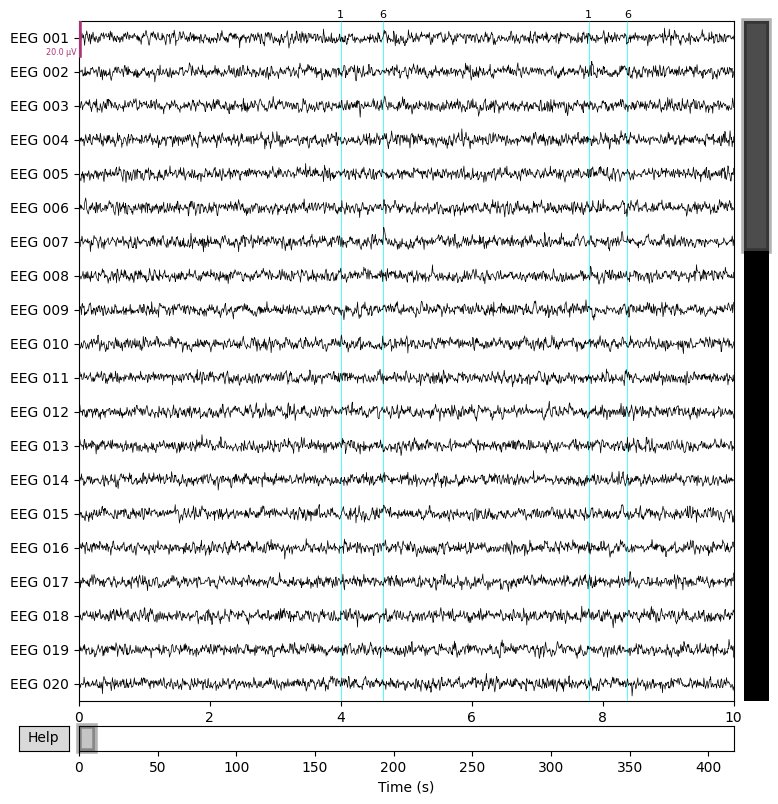

In [3]:
#Recovering the events to epoch the data (in the number of trials defined above)
generating_events = np.load(file[1])
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);

![png](README_files/README_7_1.png)

### Recovering number of events as well as actual by-trial variation

To see how well HMP does at recovering by-trial events, first we get the ground truth from our simulation. Unfortunately, with an actual dataset you don’t have access to this, of course. 

In [4]:
%matplotlib inline
#Recover the actual time of the simulated events
sim_event_times = np.reshape(np.ediff1d(generating_events[:,0],to_begin=0)[generating_events[:,2] > 1], \
           (n_trials, n_events+1))
sim_event_times_cs = np.cumsum(sim_event_times, axis=1)

## Demo for a single participant in a single condition based on the simulated data

First we read the EEG data as we would for a single participant

In [5]:
# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)


Processing participant ./dataset_README_raw.fif's continuous eeg
Reading 0 ... 208135  =      0.000 ...   416.270 secs...


/home/gweindel/miniconda3/envs/hmp_prev/lib/python3.12/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


50 trials were retained for participant ./dataset_README_raw.fif



HMP uses [xarray](https://docs.xarray.dev/en/stable/) named dimension matrices, allowing to directly manipulate the data using the name of the dimensions:



<xarray.Dataset>
Dimensions:      (participant: 1, epochs: 50, channels: 59, samples: 540)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * channels     (channels) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 533 534 535 536 537 538 539
    event_name   (epochs) object 'stimulus' 'stimulus' ... 'stimulus' 'stimulus'
    rt           (epochs) float64 0.642 0.594 0.572 0.384 ... 1.002 0.612 0.81
  * participant  (participant) <U2 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 -1.973e-07 ...
Attributes:
    sfreq:           500.0
    offset:          0
    lowpass:         40.0
    highpass:        0.10000000149011612
    lower_limit_RT:  0
    upper_limit_RT:  inf


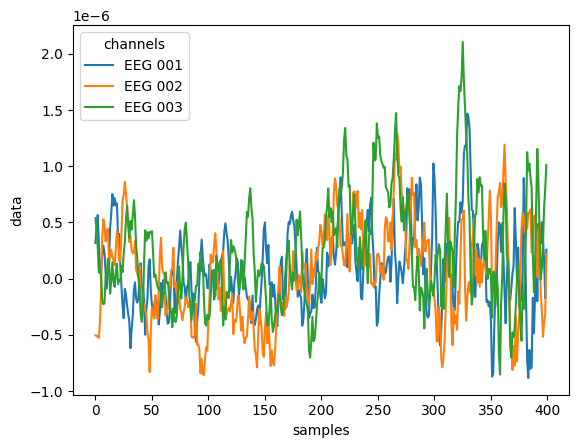

In [6]:
#example of usage of xarray
print(eeg_data)
eeg_data.sel(channels=['EEG 001','EEG 002','EEG 003'], samples=range(400))\
    .data.groupby('samples').mean(['participant','epochs']).plot.line(hue='channels');

Next we transform the data by applying a spatial principal components analysis (PCA) to reduce the dimensionality of the data. 

In this case we choose 5 principal components for commodity and speed. 
Note that if the number of components to retain is not specified, the scree plot of the PCA is displayed and a prompt ask how many PCs should be retained (in this case we specify it as building the README does not allow for prompts)

In [7]:
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# HMP model

Once the data is in the expected format, we can initialize an HMP object; note that no estimation is performed yet.


In [8]:
init = hmp.models.hmp(hmp_data, eeg_data, cpus=1)#Initialization of the model

## Estimating an HMP model

We can directly fit an HMP model without giving any info on the number of events (see tutorial 2 for a detailed explanation of the following cell:

In [9]:
estimates = init.fit()

  0%|          | 0/301 [00:00<?, ?it/s]

Transition event 1 found around sample 42
Transition event 2 found around sample 117
Transition event 3 found around sample 221
Transition event 4 found around sample 265
Estimating 4 events model
parameters estimated for 4 events model


### Visualizing results of the fit

In the previous cell we initiated an HMP model looking for default 50ms half-sine in the EEG signal. The method discovered four events, and therefore five gamma-distributed time distributions with a fixed shape of 2 and an estimated scale. We can now inspect the results of the fit.

We can directly take a look to the topologies and latencies of the events by calling ```hmp.visu.plot_topo_timecourse```



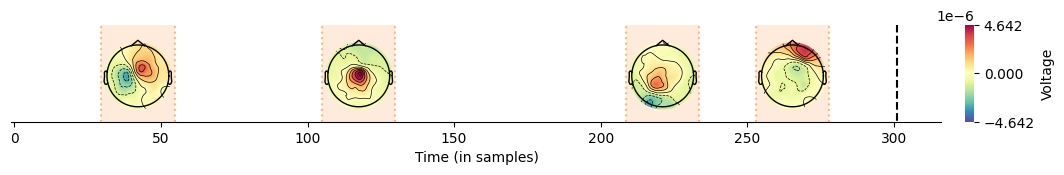

In [10]:
hmp.visu.plot_topo_timecourse(eeg_data, estimates, #Data and estimations 
                               positions, init,#position of the electrodes and initialized model
                               magnify=1, sensors=False)#Display control parameters

This shows us the electrode activity on the scalp as well as the average time of occurrence of the events.

But HMP doesn't provide point estimate but location probability of each of the detected event and that for each trial:

<Axes: xlabel='Time (in samples)', ylabel='p(event)'>

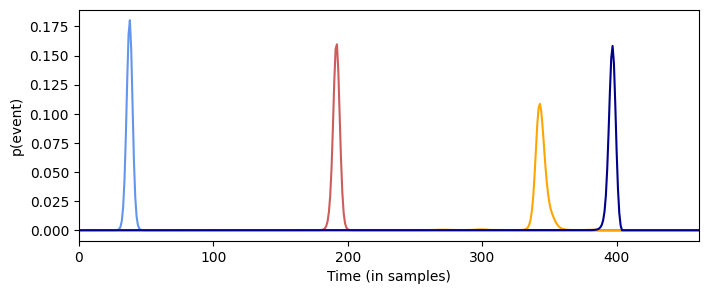

In [11]:
hmp.visu.plot_distribution(estimates.eventprobs.sel(trial_x_participant=('S0',49)), 
                            xlims=(0,np.percentile(sim_event_times.sum(axis=1), q=90)))


This then shows the likeliest event onset location in time for the last simulated trial!

## Comparing with ground truth

As we simulated the data we have access to the ground truth of the underlying generative events. We can then compare the average time of simulated event onset to the one estimated by HMP.


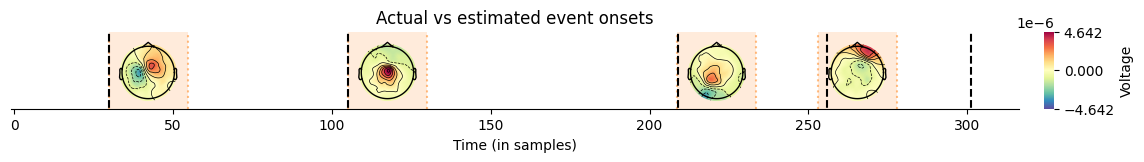

In [12]:
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=False, figsize=(13,1), title='Actual vs estimated event onsets',
        times_to_display = np.mean(np.cumsum(sim_event_times,axis=1),axis=0))


We see that the HMP recovered the exact average location of the bumps defined in the simulated data.

We can further test how well the method did by comparing the generated single trial onsets with those estimated from the HMP model

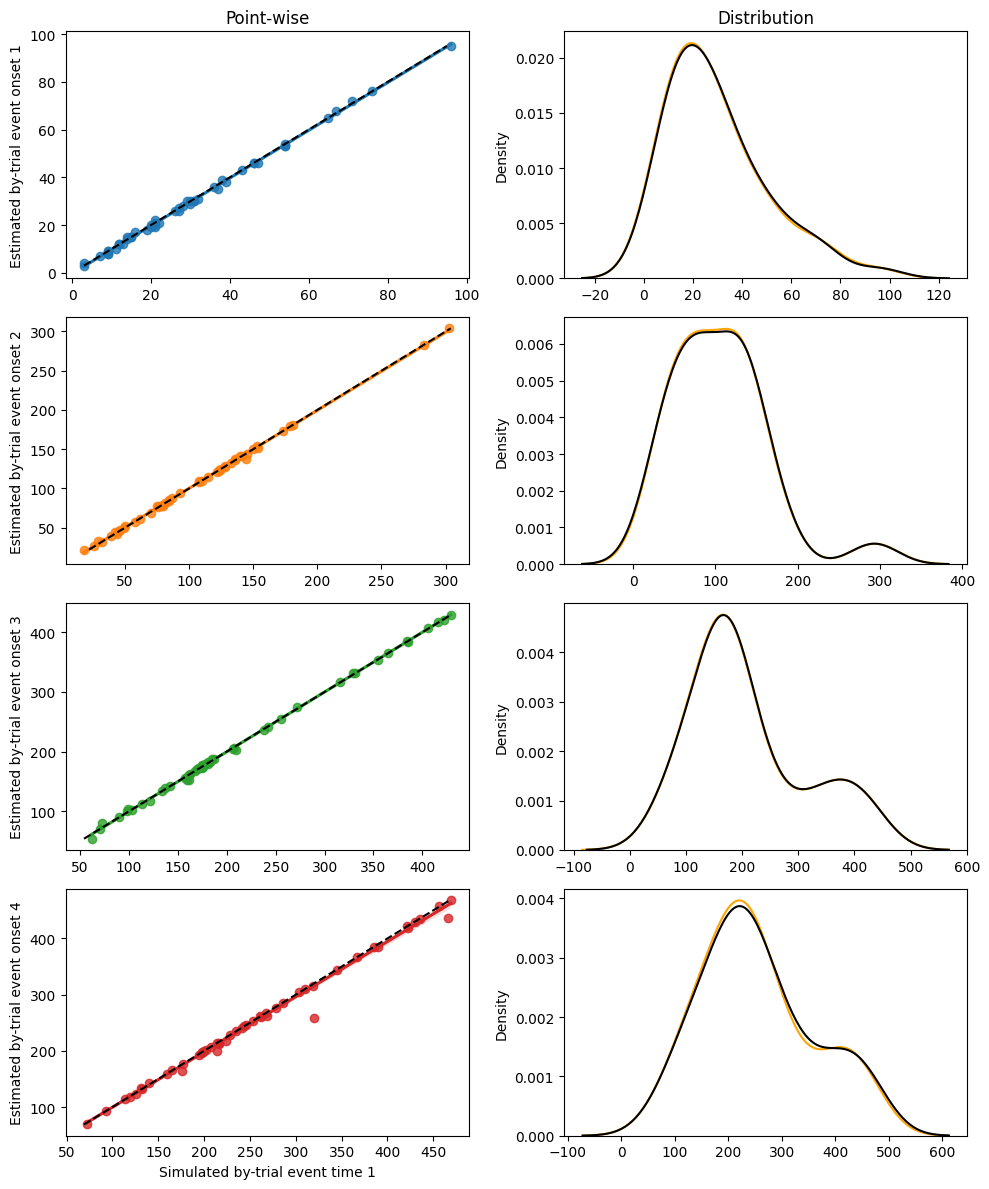

In [13]:
colors = sns.color_palette(None, n_events+1)
fig, ax = plt.subplots(n_events,2, figsize=(10,3*n_events), dpi=100, sharex=False)
i = 0
ax[0,0].set_title('Point-wise')
ax[0,1].set_title('Distribution')
ax[-1,0].set_xlabel(f'Simulated by-trial event time {i+1}')

estimated_times = init.compute_times(init, estimates, duration=False, mean=False, add_rt=False).T
for event in estimated_times:
    event_locations = sim_event_times_cs[:,i].T
    sns.regplot(x=event_locations, y=event, ax=ax[i,0], color=colors[i])
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')
    ax[i,0].set_ylabel(f'Estimated by-trial event onset {i+1}')
    sns.kdeplot(event, ax=ax[i,1], color='orange')
    sns.kdeplot(event_locations, ax=ax[i,1], color='k')
    i+= 1

plt.tight_layout();


We see that every events gets nicely recovered even on a by-trial basis!


# We have by-trial estimations. Now what?

HMP just helped us estimate at which time point single-trial events occured. There are plenty of things to do with this information.

As an example consider how average curve of traditional event related potentials (ERP) in EEG are a bad representation of the underlying single-trial event. In the following cell we do the average ERP electrode activity for 4 subselected electrodes in the classical way (stimulus centered) and in a new way that HMP allows, **by-trial resampled signal**

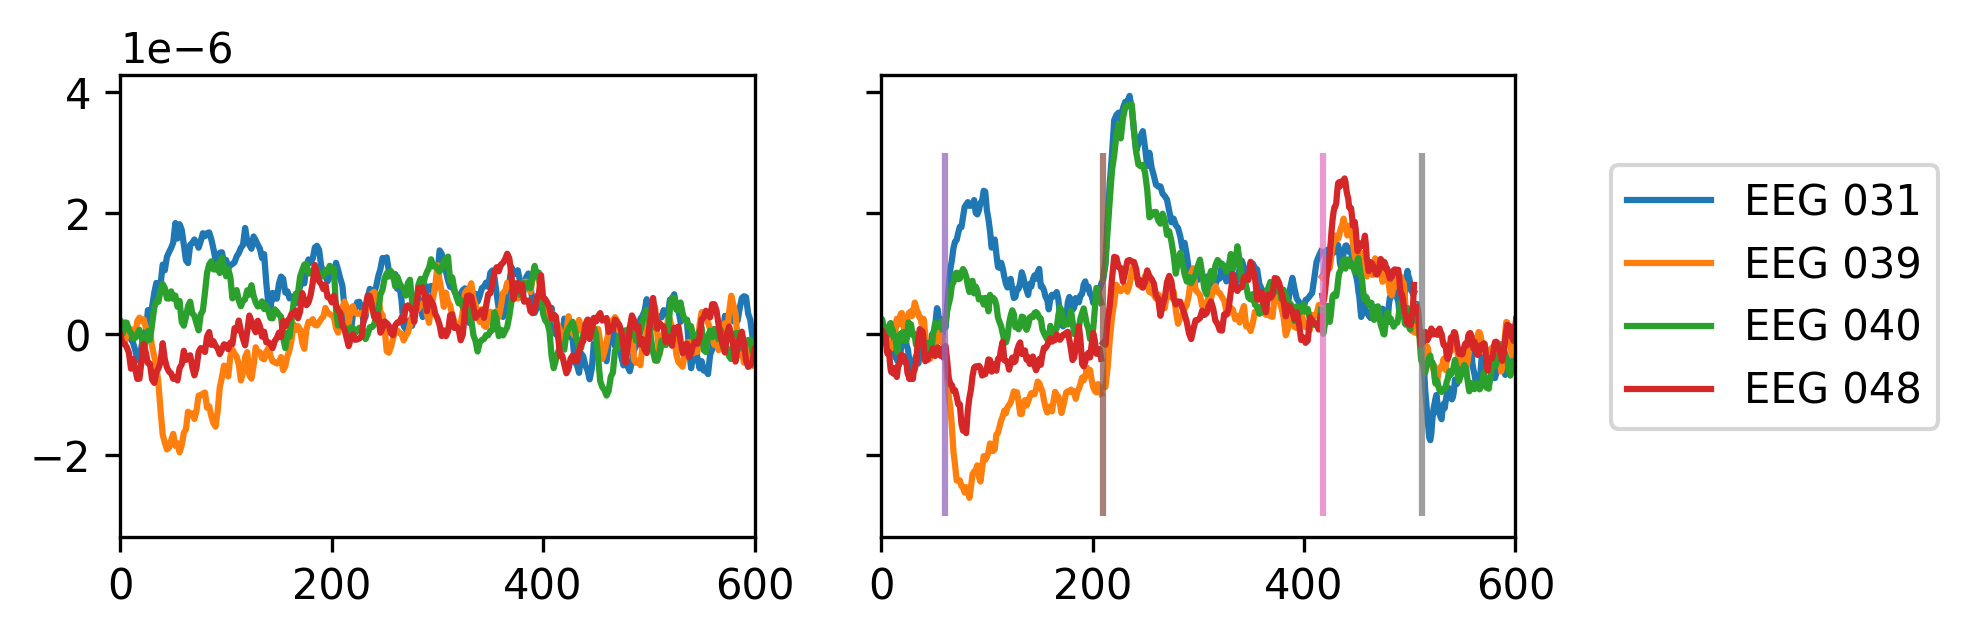

In [15]:
fig, ax = plt.subplots(1,2, figsize=(6,2), sharey=True, sharex=True, dpi=300)
colors = iter([plt.cm.tab10(i) for i in range(10)])

for channel in  ['EEG 031', 'EEG 039', 'EEG 040', 'EEG 048']:
    c = next(colors)
    fakefit = init.fit_single(2, maximization=False, verbose=False)#Just to get the stim ERP in the same format
    BRP_times = init.compute_times(init, fakefit, fill_value=0, add_rt=True)
    times = BRP_times.sel(event=[0,3])#Stim and response only
    times['event'] = [0,1]
    test = hmp.visu.erp_data(eeg_data.stack(trial_x_participant=["participant","epochs"]), times, channel)
    hmp.visu.plot_erp(times, test, c, ax[0], upsample=2, label=channel)
    BRP_times = init.compute_times(init, estimates, fill_value=0, add_rt=True)#Real estimate
    test = hmp.visu.erp_data(eeg_data.stack(trial_x_participant=["participant","epochs"]), BRP_times, channel,100)
    hmp.visu.plot_erp(BRP_times, test, c, ax[1], upsample=2)

for event in range(4):
    c = next(colors)
    ax[1].vlines(sim_event_times_cs[:,event].mean()*2, ymin=-3e-6, ymax=3e-6, color=c, alpha=.75)

plt.xlim(0,600)
ax[0].legend(bbox_to_anchor=(2.9,.85))
plt.show()

In the right panel the signal between each event is resampled to have the same duration as the average between event times (in order to be represented along with the classical ERP on the left). Do you see the gain in signal-to-noise ratio? This is because **prior to averaging we centered all trials around the most likely event onset time detected by HMP!**

Now in order to display both ERPs side-by-side we had to transform the signal by quite a bit. Instead of doing this resampling procedure we can also just look at the activity of those four electrodes in the vincinity of the detected events: 

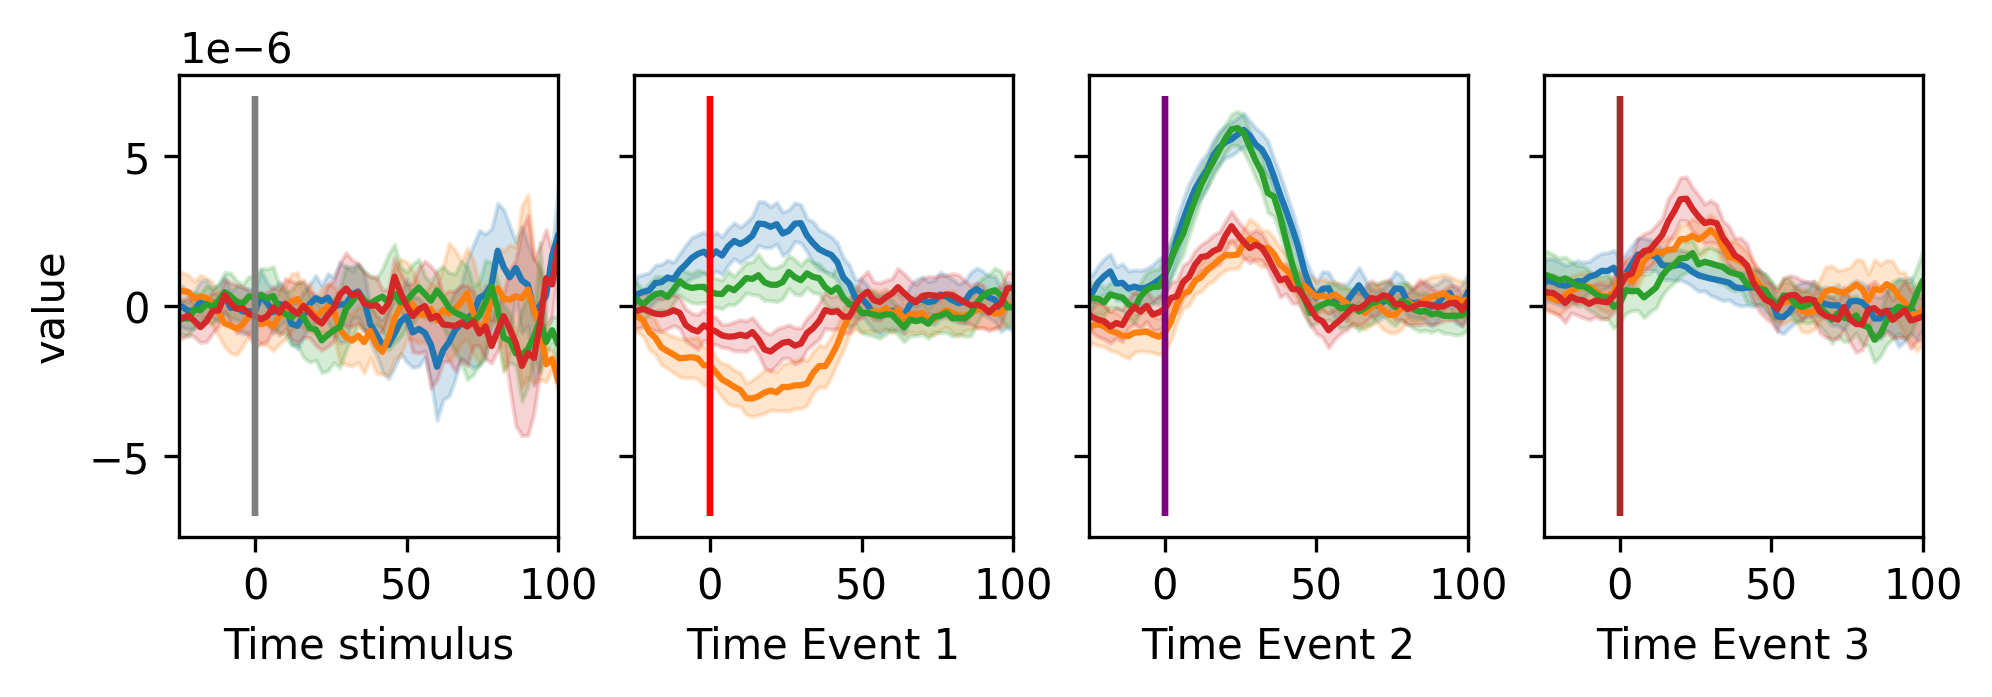

In [16]:
import pandas as pd
fig, ax = plt.subplots(1,4, figsize=(7.5,2), sharey=True, sharex=True, dpi=300)
colors = iter([plt.cm.tab10(i) for i in range(10)])

data_speed = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times_speed = init.compute_times(init, estimates.dropna('event'), fill_value=0, add_rt=True)
for channel in  ['EEG 031', 'EEG 039', 'EEG 040', 'EEG 048']:
    c = next(colors)
    baseline = 25
    ev_colors = iter(['gray', 'red', 'purple','brown','black'])
    for event in range(4):
        ev_c = next(ev_colors)
        bsl = baseline
        BRP = hmp.utils.event_times(data_speed, times_speed,channel,stage=event, baseline = bsl)
        df = pd.DataFrame(BRP).melt(var_name='Time')
        df.Time -= bsl
        df.Time = df.Time*2
        sns.lineplot(x="Time", y="value", data=df,ax=ax[event], color=c)
        ax[event].vlines(0,-7e-6,7e-6, color=ev_c, alpha=.75)
        ax[event].set_xlabel(f'Time Event {int(event)}')
ax[0].set_xlabel('Time stimulus')
plt.xlim(-25,100);

Compared to the traditional ERP representation we see that HMP provides a much better view of the underlying single-trial activities than the tradition ERP.

Now HMP is not merely a method to look at ERPs or by-trial times. A lot can be done once the estimation has been made, for example:
- Connectivity analysis starting from each event onset
- Time/frequency decomposition
- Single-trial signal analysis with, e.g. a single-trial covariate
- and so on 

### Follow-up

For examples on how to use the package on real data, or to compare event time onset across conditions see the tutorial notebooks:
- [Load EEG data (tutorial 0)](tutorials/0-Data_loading.ipynb)
- [General aspects on HMP (tutorial 1)](tutorials/1-General_aspects_on_HMP.ipynb)
- [Estimating a model (tutorial 2)](tutorials/2-Estimating_a_model.ipynb)
- [Test for the best number of events (tutorial 3)](tutorials/3-Testing_the_number_of_bumps.ipynb)
- [Looking at condition differences (tutorial 4)](4-condition_differences.ipynb)

### Bibliography
HMP is very flexible regarding what type of pattern, type of distribution and data to fit HMP to. Readers interested in the original HsMM-MVPA method (which can be seen as a specific implementation of HMP) can take a look at the paper by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) as well as the book chapter by Borst & Anderson ([2021](http://jelmerborst.nl/pubs/ACTR_HMP_MVPA_BorstAnderson_preprint.pdf)). The following list contains a non-exhaustive list of papers published using the original HsMM-MVPA method:
- Anderson, J.R., Borst, J.P., Fincham, J.M., Ghuman, A.S., Tenison, C., & Zhang, Q. (2018). The Common Time Course of Memory Processes Revealed. Psychological Science 29(9), pp. 1463-1474. [link](https://doi.org/10.1177/0956797618774526)
- Berberyan, H.S., Van Rijn, H., & Borst, J.P. (2021). Discovering the brain stages of lexical decision: Behavioral effects originate from a single neural decision process. Brain and Cognition 153: 105786. [link](https://www.sciencedirect.com/science/article/pii/S0278262621001068)
- Berberyan, H. S., van Maanen, L., van Rijn, H., & Borst, J. (2021). EEG-based identification of evidence accumulation stages in decision-making. Journal of Cognitive Neuroscience, 33(3), 510-527. [link](https://doi.org/10.1162/jocn_a_01663)
- Van Maanen, L., Portoles, O., & Borst, J. P. (2021). The discovery and interpretation of evidence accumulation stages. Computational brain & behavior, 4(4), 395-415. [link](https://link.springer.com/article/10.1007/s42113-021-00105-2)
- Portoles, O., Blesa, M., van Vugt, M., Cao, M., & Borst, J. P. (2022). Thalamic bursts modulate cortical synchrony locally to switch between states of global functional connectivity in a cognitive task. PLoS computational biology, 18(3), e1009407. [link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009407)
- Portoles, O., Borst, J.P., & Van Vugt, M.K. (2018). Characterizing synchrony patterns across cognitive task stages of associative recognition memory. European Journal of Neuroscience 48, pp. 2759-2769. [link](http://onlinelibrary.wiley.com/doi/10.1111/ejn.13817/epdf)
- Zhang, Q., van Vugt, M.K., Borst, J.P., & Anderson, J.R. (2018). Mapping Working Memory Retrieval in Space and in Time: A Combined Electroencephalography and Electrocorticography Approach. NeuroImage 174, pp. 472-484. [link](https://www.sciencedirect.com/science/article/pii/S1053811918302490)
